# Recommender Systems

This demo uses the Python [Surprise](https://github.com/NicolasHug/Surprise) library with the matrix factorization algorithm for collaborative filtering on the MovieLens 100K dataset.

## Part 1. Setup and basic EDA

First run the cell below to install the [Surprise](https://github.com/NicolasHug/Surprise) library, a [SciKit](https://www.scipy.org/scikits.html) API for building recommender systems in Python:

In [1]:
! pip install surprise

We will first load the classic [MovieLens 100K Dataset](https://grouplens.org/datasets/movielens/100k/) of online movie ratings, using the Surprise API.

**Questions:**
1. Use the code from [this GitHub Gist](https://gist.github.com/morrisalp/b6cb81bf73411c40f861f865a2b12fa9) to load the dataset. Uncomment the section that uses `train_test_split` so that the test data contains known movie ratings.

In [2]:
# your code here
import surprise
import pandas as pd

data = surprise.Dataset.load_builtin('ml-100k')
ddir = surprise.get_dataset_dir()

item_data = pd.read_csv(f'{ddir}/ml-100k/ml-100k/u.item',
                        sep='|',
                        header=None,
                        encoding='ISO-8859-1',
                        usecols=[0, 1],
                        names=['iid', 'item_name'])

def dataset2df(ds, train=True):
  df = pd.DataFrame(ds.all_ratings() if train else ds,
                    columns=['uid', 'iid', 'rating'])
  if train:
    df.uid = df.uid.apply(trainset.to_raw_uid)
    df.iid = df.iid.apply(trainset.to_raw_iid)
  df.uid = df.uid.astype(int)
  df.iid = df.iid.astype(int)
  return pd.merge(df, item_data, how='left')

def datasets2dfs(trainset, testset):
  df_train = dataset2df(trainset)
  df_test = dataset2df(testset, train=False)
  return df_train, df_test


trainset, testset = surprise.model_selection.train_test_split(data, test_size=.25)
df_train, df_test = datasets2dfs(trainset, testset)

2. Perform basic EDA, and make sure the check the following details:
  * Size of train and test datasets, features they contain and their meanings.
  * Calculate the following on the train dataset:
    * Number of unique movies and users in dataset, and how how many movies each user has rated on average.
    * Distribution of movie ratings in general, average ratings per user, and average ratings per movie.
    * Which movies are best/worst rated? (simple mean of user ratings)
    * Which movies viewed by at least 10 users are best/worst rated?
    * Which users are most/least positive in their ratings? (simple mean of movie ratings)

**Advanced note:** Actually, it is not really "fair" to judge which movies are most or least popular by mean rating, because a movie with a single 1-star rating will seem worse than one with 99 1-star ratings and a single 2-star rating. A better approach would be to estimate the standard error of the sample mean $SE=\sigma/\sqrt{n}$ for each movie, calculate a 95% CI for the sample mean using this and sort by lower or upper bounds of this interval.

In [3]:
# your code here
df_train.shape,df_test.shape

((75000, 4), (25000, 4))

In [4]:
df_train.sample(5)

,uid,iid,rating,item_name
40231,327,921,4.0,Farewell My Concubine (1993)
49535,942,750,4.0,Amistad (1997)
60381,60,507,4.0,"Streetcar Named Desire, A (1951)"
46444,308,22,4.0,Braveheart (1995)
72272,111,272,3.0,Good Will Hunting (1997)


uid : user id

iid : item id

In [5]:
nbr_uniq_mov = len(set(df_train.iid))
nbr_uniq_mov

1629

1646 unique movies.

In [6]:
nbr_uniq_user = len(set(df_train.uid))
nbr_uniq_user

943

943 unique users.

In [7]:
import numpy as np
avg_nbr_rat = df_train.iid.value_counts().mean()
avg_nbr_rat

46.04051565377532

On average, each user has rated 45 movies.

In [8]:
ratings_dist = df_train.rating.value_counts()/df_train.shape[0]*100

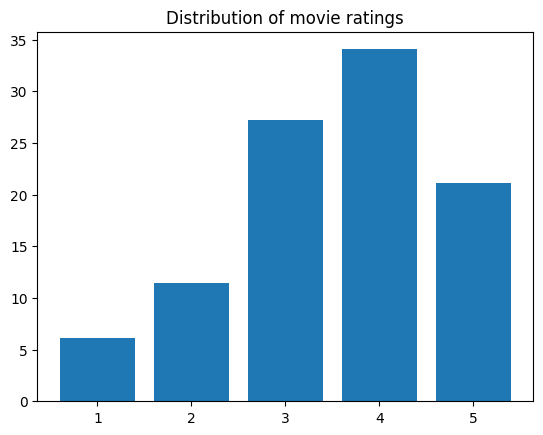

In [9]:
import matplotlib.pyplot as plt
plt.bar(ratings_dist.index, ratings_dist.values)
plt.title('Distribution of movie ratings')
plt.show()

34% of the ratings are 4

27% are 3

21% are 5

11% are 2

6% are 1

In [10]:
rat_per_user_dist = df_train.groupby('uid').rating.mean()

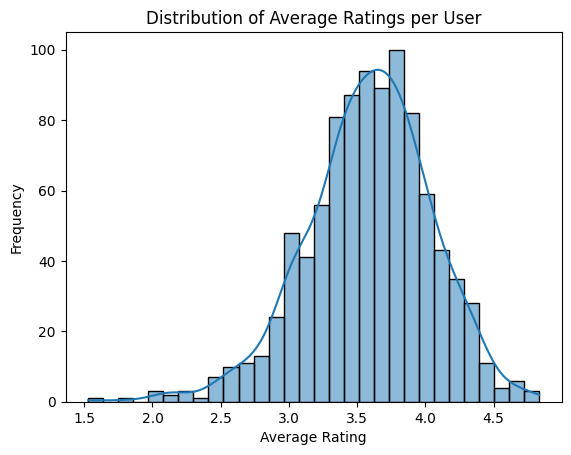

In [11]:
import seaborn as sns
sns.histplot(rat_per_user_dist, bins = 30, kde = True)
plt.title('Distribution of Average Ratings per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

In [12]:
avg_rat_per_user = df_train.groupby('uid').rating.mean().sum()/nbr_uniq_user
avg_rat_per_user

3.585487050532467

The average rating per user is 3.59

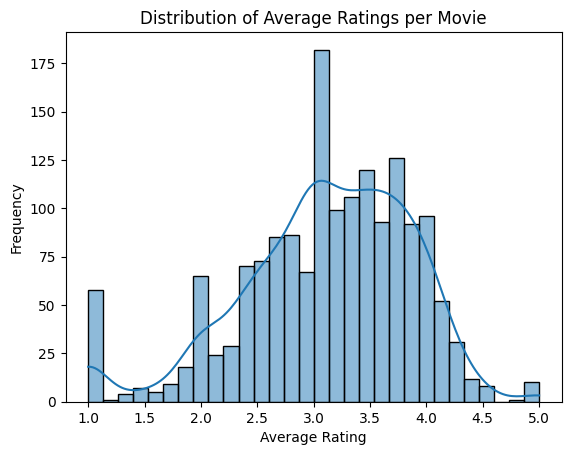

In [13]:
avg_rat_mov_dist = df_train.groupby('iid').rating.mean()
sns.histplot(avg_rat_mov_dist, bins = 30, kde = True)
plt.title('Distribution of Average Ratings per Movie')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

In [14]:
avg_rat_per_mov = df_train.groupby('iid').rating.mean().sum()/nbr_uniq_mov
avg_rat_per_mov

3.1077027851321612

The average rating per movie is 3.1

In [15]:
df_train.groupby('item_name').rating.mean().sort_values()

item_name
Somebody to Love (1994)          1.0
Daens (1992)                     1.0
King of New York (1990)          1.0
Ed (1996)                        1.0
Baton Rouge (1988)               1.0
                                ... 
Star Kid (1997)                  5.0
Prefontaine (1997)               5.0
Someone Else's America (1995)    5.0
Santa with Muscles (1996)        5.0
Great Day in Harlem, A (1994)    5.0
Name: rating, Length: 1614, dtype: float64

Worst rated :

Death in the Garden (Mort en ce jardin, La) (1956)    
Terror in a Texas Town (1958)                        
Men of Means (1998)                                   
Amityville: Dollhouse (1996)                          
Amityville: A New Generation (1993)

Best rated  :

They Made Me a Criminal (1939)                        
Great Day in Harlem, A (1994)                         
Prefontaine (1997)                                    
Someone Else's America (1995)                         
Marlene Dietrich: Shadow and Light (1996)

In [16]:
df_train.item_name.value_counts() > 9

Star Wars (1977)                 True
Contact (1997)                   True
Fargo (1996)                     True
Return of the Jedi (1983)        True
English Patient, The (1996)      True
                                ...  
Boys, Les (1997)                False
Catwalk (1995)                  False
Sunchaser, The (1996)           False
Good Man in Africa, A (1994)    False
Shooter, The (1995)             False
Name: item_name, Length: 1614, dtype: bool

In [17]:
df_train[df_train.item_name.isin((df_train.item_name.value_counts() > 9).loc[lambda x : x ].index.tolist())].groupby('item_name').rating.mean().sort_values()

item_name
Children of the Corn: The Gathering (1996)    1.333333
Body Parts (1991)                             1.545455
Mr. Magoo (1997)                              1.636364
Free Willy 3: The Rescue (1997)               1.650000
Home Alone 3 (1997)                           1.733333
                                                ...   
Casablanca (1942)                             4.429348
Shall We Dance? (1996)                        4.441176
Shawshank Redemption, The (1994)              4.461905
Schindler's List (1993)                       4.489083
Close Shave, A (1995)                         4.500000
Name: rating, Length: 1055, dtype: float64

Children of the Corn: The Gathering (1996) is the worst rated movie that has been seen by more than 10 users.

Wallace & Gromit: The Best of Aardman Animation (1996) is the best rated movie that has been seen by more than 10 users.

In [18]:
df_train.groupby('uid').rating.mean().sort_values()

uid
181    1.529231
405    1.796964
724    2.015152
685    2.062500
445    2.079208
         ...   
565    4.681818
628    4.700000
507    4.760870
849    4.823529
688    4.833333
Name: rating, Length: 943, dtype: float64

The user '181' is the user with the worst movie ratings.

The user '849' is the user with the best movie ratings.

## Part 2. Baseline Recommendations

Before we build our recommender system model, we must compare its performance to some simple baselines so that we can tell whether our model has any added value.

**Questions**:

3. If we predict the the overall mean movie rating for every movie (of the movies in the train set), what RMSE do we achieve on the test set? (For every sample in `df_test`, compare the observed rating to the overall mean.)

In [19]:
# your code here
from sklearn.metrics import mean_squared_error
y_pred_mean = [df_train.rating.mean()] * df_test.shape[0]
rmse_base_mean = np.sqrt(mean_squared_error(df_test.rating,y_pred_mean))

In [20]:
rmse_base_mean

1.1242315427783451

We get a rmse of 1.1244.

4. What RMSE do we achieve if we instead use predict using per-user mean ratings? What about per-movie mean ratings?

In [21]:
# your code here
y_pred_peruser = [avg_rat_per_user] * df_test.shape[0]
rmse_base_peruser = np.sqrt(mean_squared_error(df_test.rating,y_pred_peruser))
rmse_base_peruser

1.1252080196731555

We get a rmse of 1.1255 by using the per user mean rating.

In [22]:
y_pred_permov = [avg_rat_per_mov] * df_test.shape[0]
rmse_base_permov = mean_squared_error(y_pred_permov,df_test.rating)
rmse_base_permov

1.4485350877967456

We get a rmse of 1.4623 by using the per movie mean rating.

**Note:** Other useful baselines include giving random recommendations to users, and recommending the same (popular) movies are to all users. You could also get a better idea of the model's performance by calculating p@k (precision-at-k) metrics for these baselines. Feel free to calculate these as a bonus challenge.

## Part 3. Building a Recommender System

In this section, we will use the popular matrix factorization collaborative filtering algorithm to generate movie recommendations.

For more details on the algorithm and the implementation in Surprise, see: [Surprise documentation - Matrix factorization-based algorithms](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)

**Questions:**
5. Initialize a `surprise.SVD` object with argument `biased=False`, and save it in a variable `model`. (We covered the unbiased version of this algorithm in class. See the documentation link above for details on the algorithm with biases, which is a slight improvement to the algorithm.)

In [23]:
# your code here
from surprise import SVD
model = SVD(biased = False)

6. Fit the model to the training data using `model.fit(...)`. Note: This requires training data in the format of the variable `trainset` loaded above.

In [24]:
# your code here
model.fit(trainset)

7. Generate predictions for the test data using `model.test(...)` and save them in a variable `preds`. Note: This requires training data in the format of the variable `testset` loaded above.

In [25]:
# your code here
preds = model.test(testset)

8. Use the code given below to convert the list format of `preds` to a DataFrame `df_preds`, and examine the data it contains. It might be easier to work with this for some of the following questions.

In [26]:
### CODE FOR QUESTION 8 ####
df_preds = pd.DataFrame([
  {'uid': p.uid, 'iid': p.iid, 'rating': p.r_ui, 'estimated': p.est}
  for p in preds
])
df_preds.uid = df_preds.uid.astype(int)
df_preds.iid = df_preds.iid.astype(int)
df_preds = pd.merge(df_preds, item_data, how='left')

In [27]:
df_preds

,uid,iid,rating,estimated,item_name
0,44,208,4.0,3.696253,Young Frankenstein (1974)
1,649,275,2.0,4.176183,Sense and Sensibility (1995)
2,490,127,5.0,3.396161,"Godfather, The (1972)"
3,94,89,3.0,4.813968,Blade Runner (1982)
4,102,443,3.0,3.131227,"Birds, The (1963)"
...,...,...,...,...,...
24995,151,197,5.0,4.460720,"Graduate, The (1967)"
24996,296,498,5.0,4.457424,"African Queen, The (1951)"
24997,154,806,4.0,3.689895,Menace II Society (1993)
24998,587,316,4.0,3.832808,As Good As It Gets (1997)


9. Calculate RMSE of these predictions both using `surprise.accuracy.rmse(...)`, and by direct calculation. Verify that they give the same answer, and briefly explain how it compares to the baseline results from part 2.

In [28]:
# your code here
rmse_surprise = surprise.accuracy.rmse(preds)

RMSE: 0.9532


In [29]:
rmse_surprise_bis = np.sqrt(mean_squared_error(df_preds.rating,df_preds.estimated))
rmse_surprise_bis

0.9532466082831004

We get the same result.
We get a rmse of 0.9494 which is much better than the bets one we got with baseline models (1.1244).

## Part 4. Giving recommendations

In the end, the purpose of our model is to provide recommendations of novel movies. So let's see how to use our model to provide users with recommendations of movies that they have not actually rated yet.

**Questions:**
10. Use the code below to get all pairs (u, m) of users u and movies m such that u has not rated m (based on the train set). Examine a few rows in `unrated_data_df` to see what this data looks like.

In [30]:
### CODE FOR QUESTION 10 ###
unrated_data = trainset.build_anti_testset()

# data converted to Pandas DataFrame format for convenience:
unrated_data_df = pd.DataFrame([{'uid': x[0], 'iid': x[1]} for x in unrated_data])
unrated_data_df.uid = unrated_data_df.uid.astype(int)
unrated_data_df.iid = unrated_data_df.iid.astype(int)
unrated_data_df = pd.merge(unrated_data_df, item_data, how='left')

In [31]:
unrated_data_df

,uid,iid,item_name
0,499,280,Up Close and Personal (1996)
1,499,346,Jackie Brown (1997)
2,499,205,Patton (1970)
3,499,48,Hoop Dreams (1994)
4,499,333,"Game, The (1997)"
...,...,...,...
1461142,359,1348,Every Other Weekend (1990)
1461143,359,600,Daniel Defoe's Robinson Crusoe (1996)
1461144,359,1563,"Promise, The (Versprechen, Das) (1994)"
1461145,359,1632,Land and Freedom (Tierra y libertad) (1995)


11. Generate predictions for the unrated data using `model.test(...)` and save them in a variable `unrated_preds`. Note: This requires input data in the format of the variable `unrated_data`.

In [32]:
# your code here
unrated_preds = model.test(unrated_data)

12. Use the code given below to convert the list format of `unrated_preds` to a DataFrame `df_unrated_preds`. It might be easier to work with this for some of the next questions.

In [33]:
### CODE FOR QUESTION 12 ####
df_unrated_preds = pd.DataFrame([
  {'uid': p.uid, 'iid': p.iid, 'estimated': p.est}
  for p in unrated_preds
])
df_unrated_preds.uid = df_unrated_preds.uid.astype(int)
df_unrated_preds.iid = df_unrated_preds.iid.astype(int)
df_unrated_preds = pd.merge(df_unrated_preds, item_data, how='left')

13. Make a new DataFrame `df_top5` containing the unrated movies with top 5 predicted ratings for each user. Hint: You can do this in one line of code using Pandas and `df_unrated_preds`.

In [34]:
# your code here
df_top5 = df_unrated_preds.groupby('uid')[['uid','item_name']].head(5)

14. Show the 5 recommended movies for a user of your choice.

In [35]:
# your code here
df_top5[df_top5.uid == 180]

,uid,item_name
758462,180,Dances with Wolves (1990)
758463,180,Up Close and Personal (1996)
758464,180,Jackie Brown (1997)
758465,180,Patton (1970)
758466,180,Hoop Dreams (1994)


15. Repeat the above (parts 3 and 4), this time using the model `surprise.SVD(biased=True)`, and compare RMSE metrics.

In [36]:
# your code here
model_biased = SVD(biased = True)
model_biased.fit(trainset)
preds_biased = model_biased.test(testset)


In [37]:
df_preds_biased = pd.DataFrame([
  {'uid': p.uid, 'iid': p.iid, 'rating': p.r_ui, 'estimated': p.est}
  for p in preds_biased
])
df_preds_biased.uid = df_preds_biased.uid.astype(int)
df_preds_biased.iid = df_preds_biased.iid.astype(int)
df_preds_biased = pd.merge(df_preds_biased, item_data, how='left')

In [38]:
rmse_surprise_biased = surprise.accuracy.rmse(preds_biased)

RMSE: 0.9412


We get a rmse of 0.9305 which is lower than the one we got with the non biased model.

In [39]:
unrated_data_biased = trainset.build_anti_testset()

# data converted to Pandas DataFrame format for convenience:
unrated_data_df_biased = pd.DataFrame([{'uid': x[0], 'iid': x[1]} for x in unrated_data_biased])
unrated_data_df_biased.uid = unrated_data_df_biased.uid.astype(int)
unrated_data_df_biased.iid = unrated_data_df_biased.iid.astype(int)
unrated_data_df_biased = pd.merge(unrated_data_df_biased, item_data, how='left')

In [40]:
unrated_preds_biased = model_biased.test(unrated_data_biased)

In [41]:
df_unrated_preds_biased = pd.DataFrame([
  {'uid': p.uid, 'iid': p.iid, 'estimated': p.est}
  for p in unrated_preds_biased
])
df_unrated_preds_biased.uid = df_unrated_preds_biased.uid.astype(int)
df_unrated_preds_biased.iid = df_unrated_preds_biased.iid.astype(int)
df_unrated_preds_biased = pd.merge(df_unrated_preds_biased, item_data, how='left')

In [42]:
df_top5_biased = df_unrated_preds_biased.groupby('uid')[['uid','item_name']].head(5)

In [43]:
df_top5_biased[df_top5_biased.uid == 180]

,uid,item_name
758462,180,Dances with Wolves (1990)
758463,180,Up Close and Personal (1996)
758464,180,Jackie Brown (1997)
758465,180,Patton (1970)
758466,180,Hoop Dreams (1994)
